# Bandit Sequence Design

This notebook is for the second round design. The current design only makes use of the first round results. 

In [2]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.kernels_for_GPK import Spectrum_Kernel, Sum_Spectrum_Kernel

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading First Round Results

In [3]:
Path = '../../data/firstRound_4h.csv'

df = pd.read_csv(Path)
df.head()

,Unnamed: 0,RBS,Name,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,Group,RBS6
0,0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,3.194925,2.783529,1.798618,2.592357,0.717515,0.246643,bps,AGGAGA
1,1,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.844257,1.678119,1.290106,1.604161,0.284382,0.185590,bps,AGGAGA
2,2,GTTAAGAAGGAGATATACAT,RBS_1by1_2,0.674610,0.670263,0.643113,0.662662,0.017069,0.147150,bps,AGGAGA
3,3,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.986839,1.948917,1.101241,1.678999,0.500712,0.169798,bps,AGGAGA
4,4,TCTAAGAAGGAGATATACAT,RBS_1by1_4,1.830061,2.201733,0.983436,1.671743,0.624388,0.117162,bps,AGGAGA


In [4]:
# Data contains both the first round result and baseline data
#
# columns: 
# RBS: 20-length RBS seq
# RBS6: 6-length RBS seq, which the [7:13] positions
# variable: for first round results, denote which replication is the seq. 
# label: normalised label (zero mean and unit variance)

Path = '../../data/firstRound_4h+Baseline.csv'

df_samples = pd.read_csv(Path)
df_samples.head()

,Unnamed: 0,AVERAGE,Group,RBS,RBS6,STD,label,variable
0,0,2.592357,bps,TTTAAGAAGGAGATATACAT,AGGAGA,0.717515,3.194925,Rep1
1,1,1.604161,bps,CTTAAGAAGGAGATATACAT,AGGAGA,0.284382,1.844257,Rep1
2,2,0.662662,bps,GTTAAGAAGGAGATATACAT,AGGAGA,0.017069,0.674610,Rep1
3,3,1.678999,bps,ATTAAGAAGGAGATATACAT,AGGAGA,0.500712,1.986839,Rep1
4,4,1.671743,bps,TCTAAGAAGGAGATATACAT,AGGAGA,0.624388,1.830061,Rep1


(449, 8)

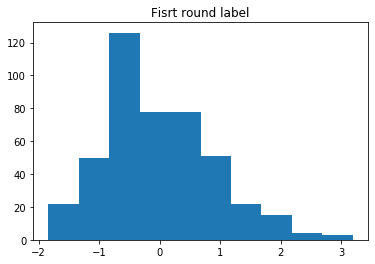

In [5]:
# extract first round result
df_FRR = df_samples[df_samples['Group'] != 'Baseline data']
data = np.asarray(df_FRR[['RBS', 'label']])
data6 = np.asarray(df_FRR[['RBS6', 'label']])
plt.hist(df_FRR['label'])
plt.title('Fisrt round label')
df_FRR.shape

## Construct feature spaces

We fix the part other the designing 6-base RBS, the 20-based RBS would be: 'TTTAAGA' + 6-base design + 'TATACAT'. The 6-base design has totally 4^6 = 4096 combinations. 

In [6]:
# create all combos

combos = [] # 20-base
combos_6 = [] # 6-base
labels = []
char_sets = ['A', 'G', 'C', 'T']
design_len = 6

# to be changed
pre_design = 'TTTAAGA'
pos_design = 'TATACAT'

for combo in itertools.product(char_sets, repeat= design_len):
    
    combo = pre_design + ''.join(combo) + pos_design
    combos_6.append(''.join(combo))
    combos.append(combo)
    labels.append(math.inf)
    
assert len(combos) == len(char_sets) ** design_len
# len(combos)

In [7]:
todesign_data = np.asarray(list(zip(combos, labels))) # 20-base
todesign6_data = np.asarray(list(zip(combos_6, labels))) # 6-base

## Setting

we use the setting getting from the cross validation of results_analysis/first_round_result_regression-Eva_on_ave.

In [8]:
embedding = 'label'
# sum_spectrum_kernel_pw: spectrum kernels for [:7], [7:13], [13:] respectively

kernel = Spectrum_Kernel(l_list = [2,3,4,5,6], weight_flag = False, padding_flag = False, gap_flag = False)
alpha = 2 

num_rounds = 1 
num_exper = 1
num_rec = 100

## Recommendations with GPUCB

beta:  1
[1604  603 2847 3012 1910 1958 1967 3199 1218 1974 1611 1940 2379 2037
 1748 2171 1221 1875 1899 3051 1979 2843 1659 2008 1291 3154 1771 3067
 1547  322 1903 2015 2427 2628 1755 3014 2836 2523 2022 2019 3019 3026
 3062 3190 1778 1329 2315  123 2068 2036 1922 1044 1307 1955 2335  379
 1858 3147 1787  582  326 1938 1995 2324 3025 2372 1227 1980 3035  635
 1222 1874 3028 1147 2034 1739 1223 1862 2003 2038 2001 2331 1983 2043
 2027 1883 1947  580  587 2006 2000 1860 3195 1915  324  331 2004 1867
 2011 2002]


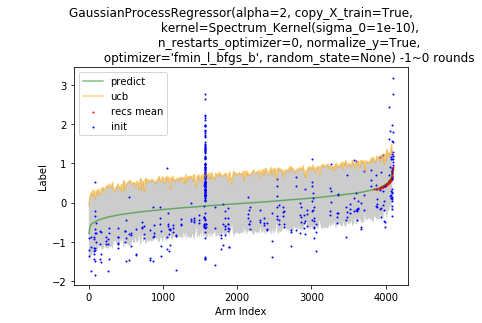

In [9]:
my_env = Rewards_env(data, embedding)
new_env = Rewards_env(todesign_data, embedding)

agent = GPUCB(new_env, num_rounds, init_list = my_env.rewards_dict, num_rec = num_rec,
          model = GaussianProcessRegressor(kernel = kernel, alpha = alpha, normalize_y =True))
rec_arms = agent.play(label_avaiable = False)

## Performance analysis

### How to balance exploration vs exploitation? 

i.e. how to choose beta?

(array([1.000e+00, 1.000e+00, 1.000e+01, 4.900e+01, 9.500e+01, 1.890e+02,
        4.520e+02, 1.191e+03, 1.669e+03, 4.390e+02]),
 array([0.27045908, 0.33232232, 0.39418557, 0.45604881, 0.51791206,
        0.57977531, 0.64163855, 0.7035018 , 0.76536504, 0.82722829,
        0.88909153]),
 <a list of 10 Patch objects>)

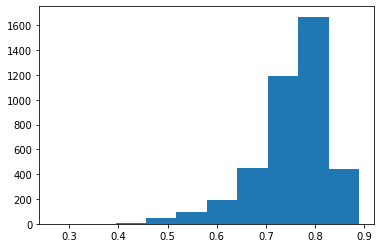

In [10]:
plt.hist(agent.sigma)

(array([2.300e+01, 1.880e+02, 6.760e+02, 1.368e+03, 1.167e+03, 5.250e+02,
        1.260e+02, 1.800e+01, 4.000e+00, 1.000e+00]),
 array([-0.79544316, -0.59604321, -0.39664327, -0.19724332,  0.00215662,
         0.20155657,  0.40095651,  0.60035645,  0.7997564 ,  0.99915634,
         1.19855629]),
 <a list of 10 Patch objects>)

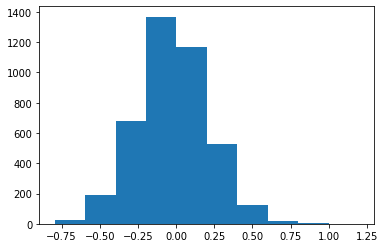

In [11]:
plt.hist(agent.mu)

The predicted mean is ranging 0~1, and the predicted sigma is ranging -2 ~ 2. Since our experiment only has one round, we can select the value of beta based on the range of predicted mean and sigma, in terms of how we want to balance the exploration and exploitation. 

The goal is to design 60 sequences where 
- around 40 for exploitation and 20 for exploration. 
- For exploitation, we control the similar between sequences below a threshold $a$, 
- and for exploration, we control the similar between sequences below a threshold $b$ ($b < a$).
- To control the similarities, we remove all sequences exceed the thresholds and put in new sequences in queue.
- The similarties can be expressed by the kernel matrix. 

One another idea, instead of recommendation sequences with maximum ucbs, we sort predicted mean and std respectively, and recommends 40 from the maximum predicted means and 20 from the maximum predicted std, with the constraint that the recommended sequences do not have too low predicted mean or too low predicted std. 

Since in the current situation, find the appropriate value of beta is tricky. 

### Similarities of rec seqs (top ucbs)

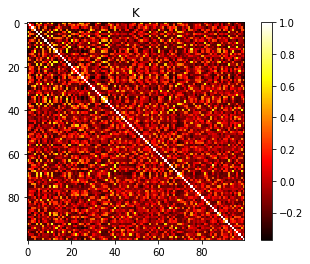

In [13]:
# similarities of rec seqs (top ucbs)

sorted_idx = np.asarray(sorted(range(len(agent.mu + agent.beta * agent.sigma)), key = lambda k : (agent.mu + agent.beta * agent.sigma)[k]))

kernel_matrix = kernel.__call__(np.asarray(combos)[sorted_idx][:num_rec], np.asarray(combos)[sorted_idx][:num_rec], plot_flag = True)

### Prediction performance on frr results

In [14]:
# prediction performance on frr results

frr_env = Rewards_env(np.asarray(df[['RBS', 'AVERAGE']]), embedding)
pred_mean, pred_std = agent.gp.predict(np.asarray(agent.to_list(frr_env.arm_features)), return_std = True)

In [15]:
df['pred mean'] = pred_mean
df['pred std'] = pred_std
df['ucb'] = df['pred mean'] + 1.5 * df['pred std']

In [16]:
df.sort_values(by = 'ucb', ascending=False).head(25)

,Unnamed: 0,RBS,Name,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,Group,RBS6,pred mean,pred std,ucb
12,12,TTTACGAAGGAGATATACAT,RBS_1by1_13,1.828821,1.419337,1.144239,1.464132,0.344482,0.219306,bps,AGGAGA,1.311159,0.537875,2.117972
11,11,TTTTAGAAGGAGATATACAT,RBS_1by1_12,2.249207,1.478876,1.148303,1.625462,0.564901,0.264738,bps,AGGAGA,1.350416,0.501833,2.103166
10,10,TTTGAGAAGGAGATATACAT,RBS_1by1_11,2.156071,2.110693,0.956545,1.741103,0.679826,0.171995,bps,AGGAGA,1.362116,0.482459,2.085805
13,13,TTTAGGAAGGAGATATACAT,RBS_1by1_14,1.502196,1.377429,1.166292,1.348639,0.169792,0.177962,bps,AGGAGA,1.328358,0.492551,2.067184
7,7,TTGAAGAAGGAGATATACAT,RBS_1by1_8,1.775556,1.689308,NaN,1.732432,0.060987,0.174465,bps,AGGAGA,1.219231,0.473059,1.928819
1,1,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.844257,1.678119,1.290106,1.604161,0.284382,0.185590,bps,AGGAGA,1.280023,0.430389,1.925607
9,9,TTTCAGAAGGAGATATACAT,RBS_1by1_10,1.726767,0.858082,0.436359,1.007069,0.657979,0.291482,bps,AGGAGA,1.045169,0.520990,1.826654
3,3,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.986839,1.948917,1.101241,1.678999,0.500712,0.169798,bps,AGGAGA,1.147333,0.413914,1.768204
0,0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,3.194925,2.783529,1.798618,2.592357,0.717515,0.246643,bps,AGGAGA,1.255761,0.319734,1.735361
14,14,TTTATGAAGGAGATATACAT,RBS_1by1_15,0.557043,0.232285,0.794119,0.527816,0.282055,0.211788,bps,AGGAGA,0.945439,0.526276,1.734853


In [17]:
df.sort_values(by = 'pred std', ascending=False)

,Unnamed: 0,RBS,Name,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,Group,RBS6,pred mean,pred std,ucb
70,70,TTTAAGAGGTCAATATACAT,RBS_RU_10,-0.228609,-0.342112,-0.104335,-0.225019,0.118929,0.148945,uni random,GGTCAA,-0.314170,0.588227,0.568169
32,32,TTTAAGAAGGTGATATACAT,RBS_1by1_33,-0.271466,-0.151800,-0.048227,-0.157164,0.111716,0.077421,bps,AGGTGA,-0.175238,0.584369,0.701315
30,30,TTTAAGAAGGCGATATACAT,RBS_1by1_31,-1.414243,-1.457957,-0.702884,-1.191695,0.423886,0.138362,bps,AGGCGA,-0.663989,0.583083,0.210635
145,172,TTTAAGATAGTCTTATACAT,RBS_RP_54,1.126117,1.970110,0.351180,1.149136,0.809711,0.047388,prob random,TAGTCT,0.402066,0.578759,1.270205
24,24,TTTAAGAACGAGATATACAT,RBS_1by1_25,1.280146,1.046771,0.953997,1.093638,0.168050,0.193737,bps,ACGAGA,0.540345,0.576116,1.404519
27,27,TTTAAGAAGCAGATATACAT,RBS_1by1_28,-0.482614,-0.686311,-0.107793,-0.425572,0.293447,0.172987,bps,AGCAGA,-0.427326,0.572189,0.430958
140,166,TTTAAGATCCGGCTATACAT,RBS_RP_48,-0.482352,-0.002993,-0.406579,-0.297308,0.257685,0.059254,prob random,TCCGGC,-0.452350,0.569149,0.401374
76,76,TTTAAGAAATGTCTATACAT,RBS_RU_16,-1.474439,-0.811631,0.145484,-0.713529,0.814405,0.623924,uni random,AATGTC,-0.603358,0.568237,0.248999
26,26,TTTAAGAATGAGATATACAT,RBS_1by1_27,-0.663860,-0.616878,0.002153,-0.426195,0.371703,0.062400,bps,ATGAGA,-0.122426,0.564835,0.724827
29,29,TTTAAGAAGTAGATATACAT,RBS_1by1_30,-0.823305,-1.716794,-0.850261,-1.130120,0.508253,0.723149,bps,AGTAGA,-0.598883,0.564132,0.247315


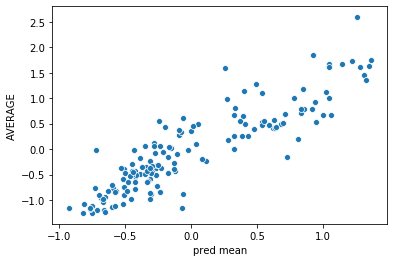

In [18]:
sns.scatterplot(df['pred mean'], df['AVERAGE'])

Since we choose alpha = 2, the prediction is ok, but not that good (with alpha = 0.1, all points are fit to the diagonal, which also could be overfitting). 

We can see, with beta = 1, the ucb ordering is similar as the pred mean ordering, i.e. we do exploitation pretty much. 

### Sensitivity of the choice of beta

We calculate the spearmanr rank-order correlation for ucbs with the different chocies of beta. We expect that the correlation is big when the difference of beta is small, vice versa.

In [19]:
from scipy.stats import spearmanr

beta_list = [0.5, 1, 1.5, 2, 2.5]
spearmanr_score = np.zeros((len(beta_list), len(beta_list)))

for i, beta_i in enumerate(beta_list):
    for j, beta_j in enumerate(beta_list):
        if j >= i:
            ucb_i = agent.mu + beta_i * agent.sigma
            ucb_j = agent.mu + beta_j * agent.sigma
            idx = np.asarray(list(set(np.argsort(ucb_i)[-60:]).union(set(np.argsort(ucb_j)[-60:]))))
            print(idx)
            spearmanr_score[i,j] = spearmanr(ucb_i[idx], ucb_j[idx])[0]
            
spearmanr_score = spearmanr_score.T + spearmanr_score
for i in range(len(beta_list)):
    spearmanr_score[i,i] = 1
    
spearmanr_score

[2068 2324 2836 1044 1307 2331 2335 2043 1329  322 1860 2372 1604 2628
 3396  327  582  331 1867 1862 3147  335  587 1874 1883  324  580  326
 1147 1915  635 3195  379  123 1938 1947 1980 1983 1222 1223 1995 1739
 1227 2000 3025 3026 2003 3028 2001 2006 2004 2002 3035 2011 2027 2034
 2036 3062 2038 1787]
[2315 2068 2324 2836 1044 1307 2331 2335 2043 1329  322 1858 1860 2372
 1604 2628 3396  327  582  331 1867 1862 3147  335  587 1874 1883  324
  580  326 3190 1147 1915  635 3195  379  123 1922 1938 1947 1955 1980
 1983 1222 1223 1995 1739 1227 3019 2000 3025 3026 2003 3028 2001 2006
 2004 2002 3035 2011 2027 2034 1778 2036 3062 2038 1787]
[2315 1547 2068 2324 2836 1044 1307 2331 2335 2043 1329  322 1858 1860
 2372 1604 2628 3396  327  582  331 1867 1862 3147  335  587 1874 1875
 1883  324  580  326 1899 1903 3190 1147 1915  635 3195  379  123 1922
 1938 1947 1955 1980 1983 1222 1223 3014 1995 1739 1227 3019 2000 3025
 3026 2003 3028 2001 2006 2004 2002 2008 3035 2011 2523 1755 2019 202

array([[ 1.        ,  0.74694708,  0.33916716,  0.09245722, -0.1176117 ],
       [ 0.74694708,  1.        ,  0.71512408,  0.46356275,  0.20137742],
       [ 0.33916716,  0.71512408,  1.        ,  0.85487945,  0.56523471],
       [ 0.09245722,  0.46356275,  0.85487945,  1.        ,  0.83492875],
       [-0.1176117 ,  0.20137742,  0.56523471,  0.83492875,  1.        ]])

From the above results, we can observe the correlation accrods with our speculation. When the beta difference is small, the correlation is high. 

## Generating recs

In [20]:
bandit20_recs = todesign_data[np.asarray(rec_arms),0]
bandit20_recs

array(['TTTAAGAGCGAGATATACAT', 'TTTAAGAACGGCTTATACAT',
       'TTTAAGACTAGTTTATACAT', 'TTTAAGACTTAGATATACAT',
       'TTTAAGAGTGTGCTATACAT', 'TTTAAGAGTCCGCTATACAT',
       'TTTAAGAGTCCTTTATACAT', 'TTTAAGATAGTTTTATACAT',
       'TTTAAGAGATAACTATACAT', 'TTTAAGAGTCTGCTATACAT',
       'TTTAAGAGCGACTTATACAT', 'TTTAAGAGTCGGATATACAT',
       'TTTAAGACGGACTTATACAT', 'TTTAAGAGTTTGGTATACAT',
       'TTTAAGAGCTGGATATACAT', 'TTTAAGACAGTCTTATACAT',
       'TTTAAGAGATAGGTATACAT', 'TTTAAGAGTGGATTATACAT',
       'TTTAAGAGTGCCTTATACAT', 'TTTAAGACTTCCTTATACAT',
       'TTTAAGAGTCTCTTATACAT', 'TTTAAGACTAGCTTATACAT',
       'TTTAAGAGCGTCTTATACAT', 'TTTAAGAGTTGCATATACAT',
       'TTTAAGAGGAACTTATACAT', 'TTTAAGATAGGACTATACAT',
       'TTTAAGAGCTCCTTATACAT', 'TTTAAGACTTTCTTATACAT',
       'TTTAAGAGCAACTTATACAT', 'TTTAAGAAGGAACTATACAT',
       'TTTAAGAGTGCTTTATACAT', 'TTTAAGAGTTGTTTATACAT',
       'TTTAAGACGGTCTTATACAT', 'TTTAAGACCGAGATATACAT',
       'TTTAAGAGCTGCTTATACAT', 'TTTAAGACTTAGCTATACAT',
       'TT

In [21]:
def gen_non_repeated_rec(frr, recs, num_rec = 60):
    frr_set = set(frr)
    repeated_rec = []
    non_repeated_rec = []
    
    for rec in reversed(recs):
        if rec not in frr_set:
            non_repeated_rec.append(rec)
            if len(non_repeated_rec) == num_rec:
                return non_repeated_rec, repeated_rec
        else:
            repeated_rec.append(rec)
    print('Rec len: ', len(non_repeated_rec))
    return non_repeated_rec, repeated_rec

In [23]:
non_repeated_rec, repeated_rec = gen_non_repeated_rec(np.asarray(df['RBS']), bandit20_recs, num_rec = 90)
print(non_repeated_rec)

['TTTAAGAGTTGCTTATACAT', 'TTTAAGAGTGACTTATACAT', 'TTTAAGAGTTGGATATACAT', 'TTTAAGAAGGACTTATACAT', 'TTTAAGAGTGTCTTATACAT', 'TTTAAGAGTGAGATATACAT', 'TTTAAGAGTTGAATATACAT', 'TTTAAGAGTTGGCTATACAT', 'TTTAAGAACGACTTATACAT', 'TTTAAGAGTCGCTTATACAT', 'TTTAAGAGTGGCTTATACAT', 'TTTAAGAGTTCCTTATACAT', 'TTTAAGAGTTTCTTATACAT', 'TTTAAGAGTCTTTTATACAT', 'TTTAAGACGAGCTTATACAT', 'TTTAAGAGTTGAGTATACAT', 'TTTAAGAGTTTGCTATACAT', 'TTTAAGAGTTGATTATACAT', 'TTTAAGAGTGAGCTATACAT', 'TTTAAGAGATAGTTATACAT', 'TTTAAGAGCTACTTATACAT', 'TTTAAGAGTTTACTATACAT', 'TTTAAGAGAGTCTTATACAT', 'TTTAAGACTTGGATATACAT', 'TTTAAGAGTGGACTATACAT', 'TTTAAGAGATAGCTATACAT', 'TTTAAGAACGTCTTATACAT', 'TTTAAGACTTGCTTATACAT', 'TTTAAGAGTCTTATATACAT', 'TTTAAGAGATACTTATACAT', 'TTTAAGACTTGAGTATACAT', 'TTTAAGACGAGGATATACAT', 'TTTAAGAGTTACTTATACAT', 'TTTAAGAGTCGACTATACAT', 'TTTAAGAACGAGCTATACAT', 'TTTAAGAGCTTCTTATACAT', 'TTTAAGATAGACTTATACAT', 'TTTAAGAGTGAACTATACAT', 'TTTAAGAAGGTCTTATACAT', 'TTTAAGACGAGTTTATACAT', 'TTTAAGAGTCCATTATACAT', 'TTTAAGAGGAGCTT

In [24]:
df[df['RBS'].isin(repeated_rec)]

,Unnamed: 0,RBS,Name,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,Group,RBS6,pred mean,pred std,ucb
0,0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,3.194925,2.783529,1.798618,2.592357,0.717515,0.246643,bps,AGGAGA,1.255761,0.319734,1.735361
21,21,TTTAAGACGGAGATATACAT,RBS_1by1_22,0.636342,0.785468,0.153062,0.524957,0.330589,0.117560,bps,CGGAGA,0.533706,0.521419,1.315834
24,24,TTTAAGAACGAGATATACAT,RBS_1by1_25,1.280146,1.046771,0.953997,1.093638,0.168050,0.193737,bps,ACGAGA,0.540345,0.576116,1.404519
36,36,TTTAAGAAGGAGCTATACAT,RBS_1by1_37,0.260930,0.035769,0.883885,0.393528,0.439331,0.188545,bps,AGGAGC,0.480036,0.537122,1.285719
60,60,TTTAAGAGTTGACTATACAT,RBS_RU_0,1.196469,1.111763,1.542289,1.283507,0.228079,0.169207,uni random,GTTGAC,0.491975,0.548410,1.314590
134,158,TTTAAGACTAGGATATACAT,RBS_RP_39,0.592961,1.570885,-0.167175,0.665557,0.871301,0.099224,prob random,CTAGGA,0.322319,0.554174,1.153579
145,172,TTTAAGATAGTCTTATACAT,RBS_RP_54,1.126117,1.970110,0.351180,1.149136,0.809711,0.047388,prob random,TAGTCT,0.402066,0.578759,1.270205


### Write into csv file

In [27]:
recs = pd.DataFrame(non_repeated_rec, columns = ['bandit'])
recs.index += 1
recs.to_csv('../../data/bandit_recs_second_round.csv')

#### Sanity test of idx consistency

In [26]:
label_seqs = np.asarray(new_env.arm_features)[np.asarray(rec_arms)]
label_dict = {'0': 'A',
              '1': 'C',
              '2': 'G',
              '3': 'T'}

rbs_seqs = []

for seq in label_seqs:
    rbs_seq = []
    for i in range(int(len(seq))):
        start = i 
        end = start + 1
        s = seq[start:end]
        rbs_seq.append(label_dict[s])
    rbs_seq = ''.join(rbs_seq)
    rbs_seqs.append(rbs_seq)

for i in range(len(rec_arms)):
    assert rbs_seqs[i] == todesign_data[rec_arms[i], 0] 
    
print('Recommned index is consistent of the todesign_data index.')

Recommned index is consistent of the todesign_data index.
